In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim
from wordcloud import WordCloud
import warnings
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report as cr

warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
dataset = pd.read_csv("IMDB_dataset_preprocessed.csv")
#dataset.drop(dataset.tail(44930).index, inplace = True) - will reduce the 50000 review dataset to 5070 reviews
reviews = [w for w in dataset["review"]]
tokenized_words = [gensim.utils.simple_preprocess(w) for w in reviews]
#tokenized_words

In [3]:
#wordcloud = WordCloud(width = 500, height = 500).generate(dataset["review"])
#plt.figure(figsize = (12, 8), facecolor = 'k')
#plt.imshow(wordcloud)
#plt.show()

In [4]:
# fastText
fastText = FastText(vector_size = 300, window = 5, min_count = 1,
 sentences = tokenized_words, epochs = 10)

In [5]:
print(fastText.wv.most_similar('movie'))

[('tvmovie', 0.9055846929550171), ('imovie', 0.8992121815681458), ('movieee', 0.8733296990394592), ('moviee', 0.8686941266059875), ('moviemag', 0.8459166288375854), ('amovie', 0.8344451189041138), ('thismovie', 0.8306980729103088), ('moviepulse', 0.8064241409301758), ('themovie', 0.7774770855903625), ('movieclips', 0.7762496471405029)]


In [6]:
print("Similarity between the words 'film' " +
"and 'movie' - fastText : ",
fastText.wv.similarity('film', 'movie'))

Similarity between the words 'film' and 'movie' - fastText :  0.7558327


In [7]:
#vocab = list(fastText.wv.key_to_index)
#X = fastText.wv[vocab]

#tsne = TSNE(n_components = 2)
#X_tsne = tsne.fit_transform(X)

#df = pd.DataFrame(X_tsne, index = vocab, columns = ['x', 'y'])

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

#ax.scatter(df['x'], df['y'])

#for word, pos in df.iterrows():
#    ax.annotate(word, pos)

In [8]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0, size), dtype = 'f')
    word_labels = [word]

    close_words = model.similar_by_word(word)
    
    arr = np.append(arr, np.array([model[word]]), axis = 0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis = 0)
        
        tsne = TSNE(n_components = 2, random_state = 0)
        np.set_printoptions(suppress = True)
        Y = tsne.fit_transform(arr)
    
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy = (x, y), xytext = (0, 0), textcoords = 'offset points')
    plt.xlim(x_coords.min() + 0.00005, x_coords.max() + 0.00005)
    plt.ylim(y_coords.min() + 0.00005, y_coords.max() + 0.00005)
    plt.title("Top 10 closest words to 'movie' - fastText", pad = 20)
    plt.show()

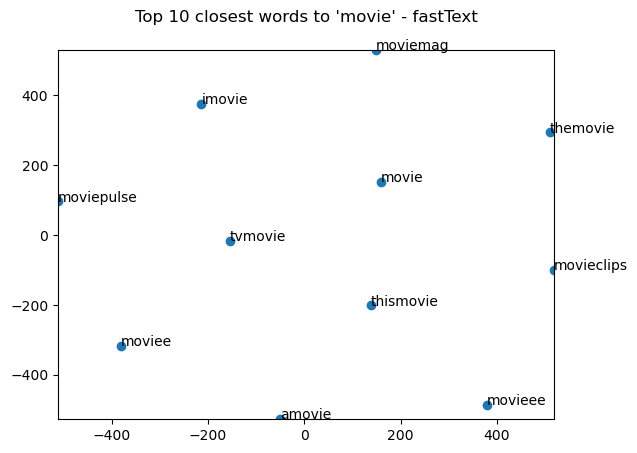

In [9]:
display_closestwords_tsnescatterplot(fastText.wv, 'movie', 300)

In [10]:
def getReviewVector(doc):
    return np.mean([fastText.wv[word] for word in doc if word in fastText.wv.index_to_key], axis = 0)

In [11]:
x = []
for i in range(len(tokenized_words)):
    x.append(getReviewVector(tokenized_words[i]))

In [12]:
y = pd.get_dummies(dataset["sentiment"])
y = y.iloc[:,1].values
y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [14]:
fastText_NB = GaussianNB().fit(X_train, y_train)

In [15]:
fastText_NB_prediction = fastText_NB.predict(X_test)

In [16]:
score = accuracy_score(y_test, fastText_NB_prediction)
print(score)
print(cr(y_test, fastText_NB_prediction))

0.7596
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      5035
           1       0.75      0.77      0.76      4965

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

